Курсовая работа по дисциплине: Паровые и Газовые турбины.

| ФИО | Вариант | Тип турбины   | P0, МПа | t0, °C | Pпп, МПа | tпп, °C | Pк, кПа  | tпв,°C | Nэ, МВт | Z, шт | dр.с., м | n, c-1 | H0, кДж/кг |
|------|------|------|------|------|------|------|------|------|------|------|------|------|------|
|   Бонадыков Никита Михайлович   | 2 | К-800-23,5 ЛМЗ | 24 | 555 | 3,66 | 552 | 3,4 | 271 | 840 | 8 | 1,2 | 60 | 90 -110 |

In [115]:
#Импорт библиотек
import iapws
from iapws import IAPWS97 as gas
import matplotlib.pyplot as plt
import numpy as np

In [116]:
#Инициализация параметров расчета  
MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

In [117]:
#Дано
electrical_power = 840 * (10 ** 6)    
p0 = 24 * MPa
t0 = 555
pk = 3.4 * kPa
p_middle = 3.4 * MPa
t_middle = 552
t_feed_water = 271
p_feed_water = 1.4 * p0
z = 8
internal_efficiency = 0.85
mechanical_efficiency = 0.992
generator_efficiency = 0.99

In [118]:
#Расчет погрешности 
delta_p0 = 0.05 * p0
delta_p_middle = 0.1 * p_middle
delta_p_1 = 0.03 * p_middle
#Расчет реальных параметров точек
real_p0 = p0 - delta_p0
real_p1t = p_middle + delta_p_middle
real_p_middle = p_middle - delta_p_1

In [119]:
#Расчет начальных точек 
_point_0 = gas(P = p0 * unit, T=to_kelvin(t0))
point_0 = gas(P=real_p0 * unit, h=_point_0.h)
point_1t = gas(P=real_p1t * unit, s=_point_0.s)

hp_heat_drop = (_point_0.h - point_1t.h) * internal_efficiency
h_1 = point_0.h - hp_heat_drop
point_1 = gas(P=real_p1t * unit, h=h_1)

In [120]:
#Расчет точек промперегрева
_point_middle = gas(P=p_middle * unit, T=to_kelvin(t_middle))
point_middle = gas(P=real_p_middle * unit, h=_point_middle.h)
point_2t = gas(P=pk * unit, s=_point_middle.s)

lp_heat_drop = (_point_middle.h - point_2t.h) * internal_efficiency
h_2 = point_middle.h - lp_heat_drop
point_2 = gas(P=pk * unit, h=h_2)

efficiency_hp = (_point_0.h - point_1.h) / (_point_0.h - point_1t.h)
efficiency_lp = (_point_middle.h - point_2.h) / (_point_middle.h - point_2t.h)

In [121]:
#Расчет точек питательной воды и воды после конденсатора 
point_k_water = gas(P=pk * unit, x=0)
point_feed_water = gas(P=p_feed_water * unit, T=to_kelvin(t_feed_water))

In [122]:
numenator_without = point_2.T * (_point_middle.s - point_k_water.s)
denumenator_without = (point_0.h - point_1t.h) + (point_middle.h - point_k_water.h)
without_part = 1 - (numenator_without / denumenator_without)

numenator_infinity = point_2.T * (_point_middle.s - point_feed_water.s)
denumenator_infinity = (point_0.h - point_1t.h) + (point_middle.h - point_feed_water.h)
infinity_part = 1 - (numenator_infinity / denumenator_infinity)

ksi_infinity = 1 - (without_part / infinity_part)


In [123]:
coeff = (point_feed_water.T - point_2.T) / (to_kelvin(374.2) - point_2.T)

In [124]:
ksi = 0.9 * ksi_infinity

In [125]:
eff_num = hp_heat_drop + lp_heat_drop
eff_denum = hp_heat_drop + (point_middle.h - point_k_water.h)
#Подсчет эфективности 
efficiency = (eff_num / eff_denum) * (1 / (1 - ksi))

In [126]:
estimated_heat_drop = efficiency * ((point_0.h - point_feed_water.h) + (point_middle.h - point_1.h))

In [127]:
#Расчет расхода в турбину на входе
inlet_mass_flow = electrical_power / (estimated_heat_drop * 1000 * mechanical_efficiency * generator_efficiency)

In [128]:
#Расчет расхода в конденсатор
condenser_mass_flow = (
    electrical_power /
    ((point_2.h - point_k_water.h) * 1000 * mechanical_efficiency * generator_efficiency) * ((1 / efficiency) - 1)
)

In [129]:
print("Массовый расход в турбину на входе", inlet_mass_flow)
print("Массовый расход в конденсатор:", condenser_mass_flow)

Массовый расход в турбину на входе 659.3819522129577
Массовый расход в конденсатор: 434.98665331279125


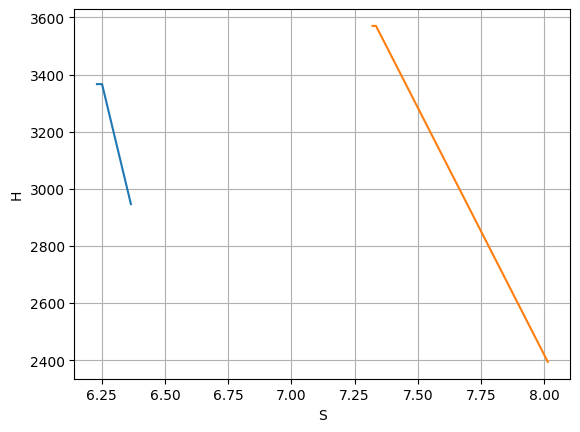

In [130]:
x1 = [_point_0.s,point_0.s,point_1.s]
y1 = [_point_0.h,point_0.h,point_1.h]

x2 = [_point_middle.s,point_middle.s,point_2.s]
y2 = [_point_middle.h,point_middle.h,point_2.h]
plt.xlabel("S")
plt.ylabel("H")
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.grid()
plt.show()